In [68]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, re
from sklearn.metrics import roc_auc_score, roc_curve, auc
from glob import glob

sys.path.append("./python/")
from tcr_utils import blosum50_aa, pca15_aaidx, load_tcrs, load_tcrs2, enc_list_bl_max_len
from tcr_cnn import build_cnn_model
from tcr_transformer import build_transformer_model

tokenizer = keras.preprocessing.text.Tokenizer(char_level=True, lower=False)
tokenizer.fit_on_texts('ARNDCEQGHILKMFPSTWYV')

In [69]:
# load train and test data
tcrs_train_n = load_tcrs("data/TrainingData/NormalCDR3.txt")
tcrs_train_t = load_tcrs("data/TrainingData/TumorCDR3.txt")
tcrs_test_n = load_tcrs("data/TrainingData/NormalCDR3_test.txt")
tcrs_test_t = load_tcrs("data/TrainingData/TumorCDR3_test.txt")

In [77]:
# encode TCRs with BLOSUM50
X_train_blosum50 = np.concatenate(
    [enc_list_bl_max_len(tcrs_train_n, blosum50_aa, 20),
     enc_list_bl_max_len(tcrs_train_t, blosum50_aa, 20)], axis=0)
y_train = np.concatenate([np.zeros(len(tcrs_train_n)), np.ones(len(tcrs_train_t))])

X_test_blosum50 = np.concatenate(
    [enc_list_bl_max_len(tcrs_test_n, blosum50_aa, 20),
     enc_list_bl_max_len(tcrs_test_t, blosum50_aa, 20)], axis=0)

y_test = np.concatenate([np.zeros(len(tcrs_test_n)), np.ones(len(tcrs_test_t))])

# load CNN+BLOSUM50 pretrained model
cnn_mod_blosum50 = build_cnn_model(maxlen=20, n_feature=20)
cnn_mod_blosum50.compile(loss="binary_crossentropy",
                         optimizer=keras.optimizers.Adam(learning_rate=0.001),
                         metrics=['accuracy'])
cnn_mod_blosum50.load_weights('models/cnn_blosum50_weights.h5')

# evaluate CNN+BLOSUM50 model on test dataset
print("CNN+BLOSUM50 on test dataset:")
y_test_pred_blosum50 = cnn_mod_blosum50.predict(X_test_blosum50)
loss_test_blosum50, acc_test_blosum50 = cnn_mod_blosum50.evaluate(X_test_blosum50, y_test, verbose=0)
print("Loss =", loss_test_blosum50,
      "Acc =", acc_test_blosum50,
      "AUC =", roc_auc_score(y_test, y_test_pred_blosum50))

CNN+BLOSUM50 on test dataset:
Loss = 0.3749978244304657 Acc = 0.8292412757873535 AUC = 0.9074855363919596


In [79]:
# encode TCRs with PCA15
X_train_pca15 = np.concatenate(
    [enc_list_bl_max_len(tcrs_train_n, pca15_aaidx, 20),
     enc_list_bl_max_len(tcrs_train_t, pca15_aaidx, 20)], axis=0)

X_test_pca15 = np.concatenate(
    [enc_list_bl_max_len(tcrs_test_n, pca15_aaidx, 20),
     enc_list_bl_max_len(tcrs_test_t, pca15_aaidx, 20)], axis=0)

# load CNN+PCA15 pretrained model
cnn_mod_pca15 = build_cnn_model(maxlen=20, n_feature=15)
cnn_mod_pca15.compile(loss="binary_crossentropy",
                      optimizer=keras.optimizers.Adam(learning_rate=0.001),
                      metrics=['accuracy'])
cnn_mod_pca15.load_weights('models/cnn_pca15_weights.h5')

# evaluate CNN+PCA15 model on test dataset
print("CNN+PCA15 on test dataset:")
y_test_pred_pca15 = cnn_mod_pca15.predict(X_test_pca15)
loss_pca15, acc_pca15 = cnn_mod_pca15.evaluate(X_test_pca15, y_test, verbose=0)
print("Loss =", loss_pca15,
      "Acc =", acc_pca15,
      "AUC =", roc_auc_score(y_test, y_test_pred_pca15))

CNN+PCA15 on test dataset:
Loss = 0.4059675335884094 Acc = 0.8215938806533813 AUC = 0.8987395952298705


In [80]:
# encode TCRs as a sequence of integers to be used as input to the embedding layer
X_train_emb = np.concatenate(
    [keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences(tcrs_train_n), maxlen=20),
     keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences(tcrs_train_t), maxlen=20)],
    axis=0)

X_test_emb = np.concatenate(
    [keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences(tcrs_test_n), maxlen=20),
     keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences(tcrs_test_t), maxlen=20)],
    axis=0)

# load pretrained transformer model
transformer_mod = build_transformer_model()
transformer_mod.load_weights('models/transformer_weights.h5')

# evaluate transformer encoder model on test dataset
print("Transformer on test dataset:")
y_test_pred_transformer = transformer_mod.predict(X_test_emb)[:,1]
loss_test_transformer, acc_test_transformer = transformer_mod.evaluate(X_test_emb, y_test, verbose=0)
print("Loss =", loss_test_transformer,
      "Acc =", acc_test_transformer,
      "AUC =", roc_auc_score(y_test, y_test_pred_transformer))

Transformer on test dataset:
Loss = 0.33855780959129333 Acc = 0.8533239364624023 AUC = 0.9293818340392828


<Figure size 432x288 with 0 Axes>

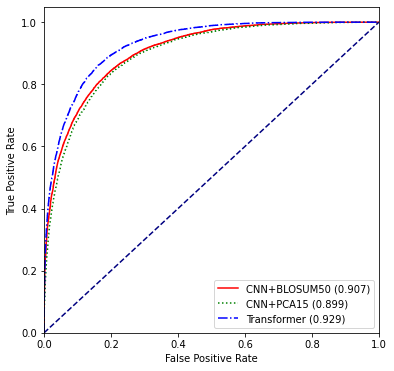

In [81]:
# plot the ROC curves of the three models on the test dataset
fpr_blosum50, tpr_blosum50, threshold_blosum50 = roc_curve(y_test, y_test_pred_blosum50)
roc_auc_blosum50 = auc(fpr_blosum50, tpr_blosum50)

fpr_pca15, tpr_pca15, threshold_pca15 = roc_curve(y_test, y_test_pred_pca15)
roc_auc_pca15 = auc(fpr_pca15, tpr_pca15)

fpr_transformer, tpr_transformer, threshold_transformer = roc_curve(y_test, y_test_pred_transformer)
roc_auc_transformer = auc(fpr_transformer, tpr_transformer)

plt.figure()
plt.figure(figsize = (6,6))
plt.plot(fpr_blosum50, tpr_blosum50, color = 'r', linestyle="solid", label = 'CNN+BLOSUM50 (%0.3f)' % roc_auc_blosum50)
plt.plot(fpr_pca15, tpr_pca15, color = 'g', linestyle="dotted", label = 'CNN+PCA15 (%0.3f)' % roc_auc_pca15)
plt.plot(fpr_transformer, tpr_transformer, color = 'blue', linestyle="dashdot", label = 'Transformer (%0.3f)' % roc_auc_transformer)

plt.plot([0, 1], [0,1 ], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
#plt.savefig("auc_test.pdf")
plt.show()

In [104]:
# evaluate transformer encoder model on the NSCLC dataset
nsclc_path = 'data/NSCLC/'
nsclc_samples = glob(os.path.join(nsclc_path, '*.tsv'))

nsclc_caScore = []
for fname in nsclc_samples:
    tcrs = load_tcrs2(fname)
    X = keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences(tcrs), maxlen=20)
    proba = transformer_mod.predict(X)[:,1]
    nsclc_caScore.append(np.mean(proba))

In [105]:
health_path = 'data/Health/'
health_samples = glob(os.path.join(health_path, '*.tsv'))

health_caScore = []
for fname in health_samples:
    tcrs = load_tcrs2(fname)
    X = keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences(tcrs), maxlen=20)
    proba = transformer_mod.predict(X)[:,1]
    health_caScore.append(np.mean(proba))

In [106]:
# AUC for transformer encoder model
y_test = np.concatenate(
    [np.zeros(len(health_caScore)), np.ones(len(nsclc_caScore))])
y_pred = np.concatenate([health_caScore, nsclc_caScore])
roc_auc_score(y_test, y_pred)

0.9697844112769486

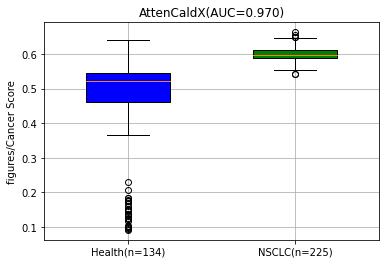

In [85]:
# boxplot
colors = ['b', 'g']
labels = ['Health(n=134)', 'NSCLC(n=225)']
cascore_list = [health_caScore, nsclc_caScore]

bplot = plt.boxplot(
    cascore_list,
    whis=1.5, # IQR multiplier
    widths=.5,
    sym='o', # outlier symbol
    labels=labels,
    patch_artist=True
)

for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)
    
plt.title('AttenCaldX(AUC=0.970)')
plt.ylabel('figures/Cancer Score')
plt.grid()
#plt.savefig('AttenCaldX_boplot.pdf')
plt.show()

In [43]:
df_nsclc = pd.read_table("../../DeepLION-master/DeepLION_NSCLC.tsv")
df_health = pd.read_table("../../DeepLION-master/DeepLION_Health.tsv")

In [55]:
y_pred_deeplion = np.concatenate([df_health.Probability, df_nsclc.Probability])

In [54]:
roc_auc_score(y_test, y_pred_deeplion)

0.7039137645107794

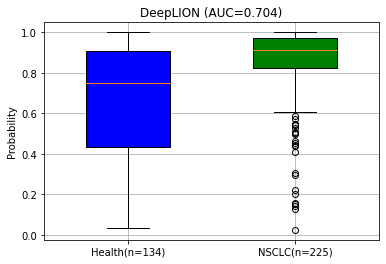

In [66]:
colors = ['b', 'g']
labels = ['Health(n=134)', 'NSCLC(n=225)']
cascore_list = [df_health.Probability, df_nsclc.Probability]

bplot = plt.boxplot(
    cascore_list,
    whis=1.5, # IQR multiplier
    widths=.5,
    sym='o', # outlier symbol
    labels=labels,
    patch_artist=True
)

for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)
    
plt.title('DeepLION (AUC=0.704)')
plt.ylabel('Probability')
plt.grid()
#plt.savefig('figures/DeepLION_boplot.pdf')
plt.show()

<Figure size 432x288 with 0 Axes>

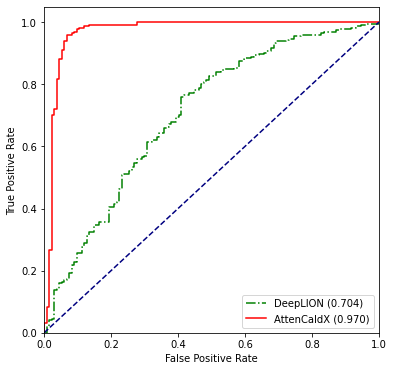

In [117]:
fpr_deeplion, tpr_deeplion, threshold_deeplion = roc_curve(y_test, y_pred_deeplion)
roc_auc_deeplion = auc(fpr_deeplion, tpr_deeplion)

fpr_transformer, tpr_transformer, threshold_transformer = roc_curve(y_test, y_pred)
roc_auc_transformer = auc(fpr_transformer, tpr_transformer)

plt.figure()
plt.figure(figsize = (6,6))
plt.plot(fpr_deeplion, tpr_deeplion, color = 'g', linestyle="dashdot", label = 'DeepLION (%0.3f)' % roc_auc_deeplion)
plt.plot(fpr_transformer, tpr_transformer, color = 'red', linestyle="solid", label = 'AttenCaldX (%0.3f)' % roc_auc_transformer)

plt.plot([0, 1], [0,1 ], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
#plt.savefig("figures/AUC_compare.pdf")
plt.show()

In [107]:
nsclc_caScore2 = []

# evaluate transformer encoder model on the NSCLC dataset weighted by frequencies
for fname in nsclc_samples:
    df_filter = load_tcrs3(fname)
    X = keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences(df_filter.aaSeqCDR3), maxlen=20)
    proba = transformer_mod.predict(X)[:,1]
    nsclc_caScore2.append(np.sum(proba*df_filter.cloneFraction) / np.sum(df_filter.cloneFraction))

In [108]:
health_caScore2 = []
for fname in health_samples:
    df_filter = load_tcrs3(fname)
    X = keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences(df_filter.aaSeqCDR3), maxlen=20)
    proba = transformer_mod.predict(X)[:,1]
    health_caScore2.append(np.sum(proba*df_filter.cloneFraction) / np.sum(df_filter.cloneFraction))

In [109]:
y_pred2 = np.concatenate([health_caScore2, nsclc_caScore2])
roc_auc_score(y_test, y_pred2)

0.8291210613598673

<Figure size 432x288 with 0 Axes>

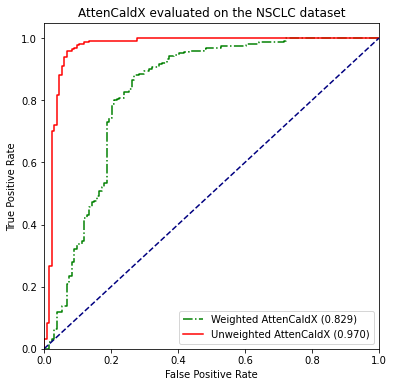

In [119]:
fpr_transformer, tpr_transformer, threshold_transformer = roc_curve(y_test, y_pred)
roc_auc_transformer = auc(fpr_transformer, tpr_transformer)

fpr_transformer2, tpr_transformer2, threshold_transformer2 = roc_curve(y_test, y_pred2)
roc_auc_transformer2 = auc(fpr_transformer2, tpr_transformer2)

plt.figure()
plt.figure(figsize = (6,6))
plt.plot(fpr_transformer2, tpr_transformer2, color = 'g', linestyle="dashdot", label = 'Weighted AttenCaldX (%0.3f)' % roc_auc_transformer2)
plt.plot(fpr_transformer, tpr_transformer, color = 'red', linestyle="solid", label = 'Unweighted AttenCaldX (%0.3f)' % roc_auc_transformer)

plt.plot([0, 1], [0,1 ], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title("AttenCaldX evaluated on the NSCLC dataset")
plt.savefig("figures/AUC_commpare_weighted.pdf")
plt.show()